<a href="https://www.kaggle.com/code/joanwachuka/ksl-sign?scriptVersionId=297172026" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))


In [2]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout ,Normalization , BatchNormalization, Bidirectional, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from matplotlib import animation

2026-02-11 15:02:36.191922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770822156.393973      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770822156.457234      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770822156.956352      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770822156.956408      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770822156.956411      24 computation_placer.cc:177] computation placer alr

In [3]:
import numpy as np
import cv2
from PIL import Image
from IPython.display import display, clear_output
import time

In [4]:

DATA_PATH = "/kaggle/input/ksl-hand-landmarks/kslnewdata/kslnewdata/dataset"
MAX_FRAMES = 60
FEATURES = 126
EPOCHS = 20  
BATCH_SIZE = 16
LEARNING_RATE = 0.001
LABELS = ['a', 'is', 'mother', 'my', 'this'] 


In [5]:
# Load data 
X, y = [], []
for label_idx, label in enumerate(LABELS):
    label_dir = os.path.join(DATA_PATH, label)
    for file in os.listdir(label_dir):
        if file.endswith('.npy'):
            seq = np.load(os.path.join(label_dir, file))
            X.append(seq)
            y.append(label_idx)


print("Number of sequences:", len(X))
print("Example sequence shape:", X[0].shape)

# Convert to arrays
X = np.array(X, dtype=object)
y = np.array(y)


# Pad sequences
X_padded = pad_sequences(X, maxlen=MAX_FRAMES, dtype='float32', padding='post', truncating='post')
y_onehot = to_categorical(y, num_classes=len(LABELS))
print("X shape after padding:", X_padded.shape)



Number of sequences: 100
Example sequence shape: (23, 126)
X shape after padding: (100, 60, 126)


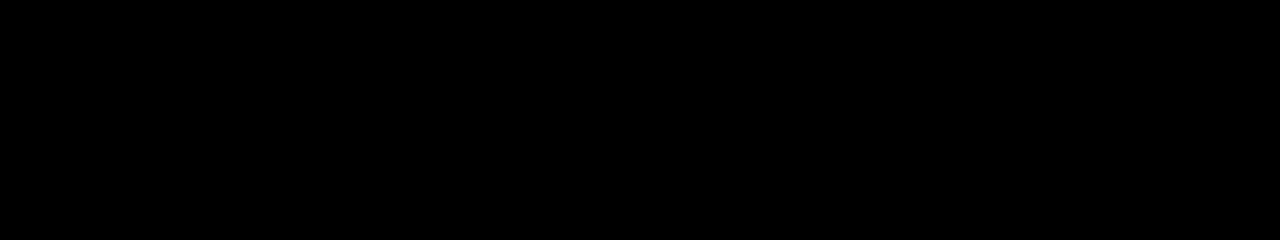

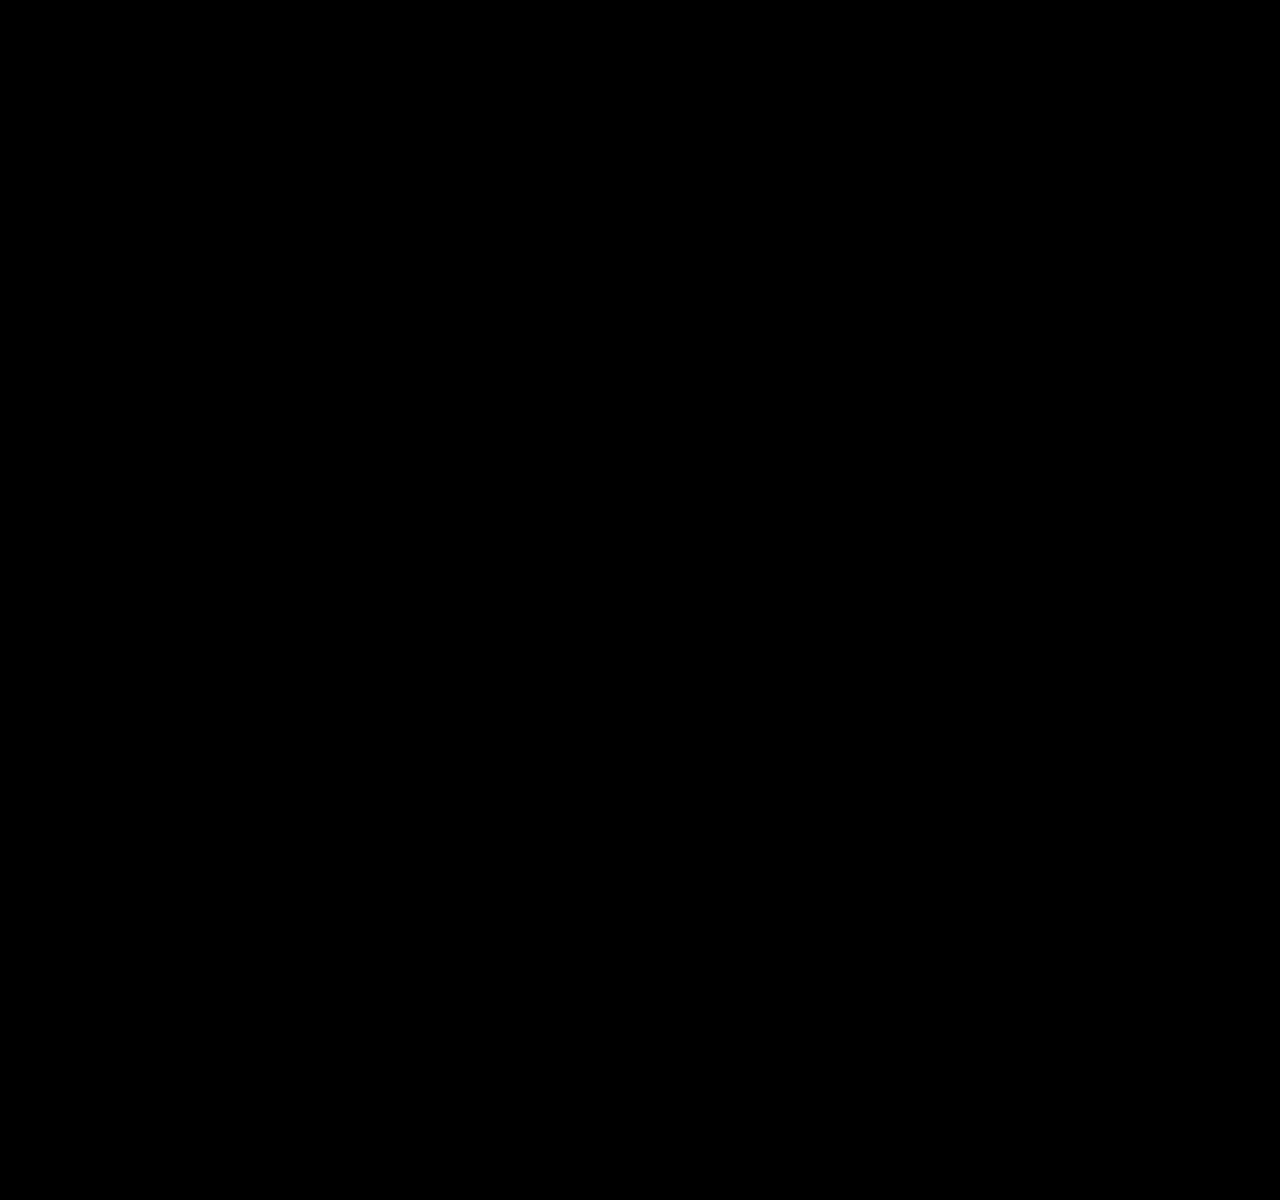

In [6]:

HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (5,9),(9,10),(10,11),(11,12),
    (9,13),(13,14),(14,15),(15,16),
    (13,17),(17,18),(18,19),(19,20),
    (0,17)
]

# Draw a single frame for one sequence
def draw_frame(frame_data, width=320, height=240):
    canvas = np.zeros((height, width, 3), dtype=np.uint8)
    if np.all(frame_data == 0):
        return canvas
    left = frame_data[:63].reshape(21,3)
    right = frame_data[63:].reshape(21,3)

    def draw_hand(hand):
        for (start,end) in HAND_CONNECTIONS:
            x1 = int(hand[start][0]*width)
            y1 = int(hand[start][1]*height)
            x2 = int(hand[end][0]*width)
            y2 = int(hand[end][1]*height)
            cv2.line(canvas,(x1,y1),(x2,y2),(0,255,0),1)
        for x,y,_ in hand:
            cv2.circle(canvas,(int(x*width),int(y*height)),2,(0,0,255),-1)

    if not np.all(left==0):
        draw_hand(left)
    if not np.all(right==0):
        draw_hand(right)
    return canvas

# Animate multiple sequences as a row of 4 columns
def animate_row(sequences, width=320, height=240, pause=0.08):
    # Ensure 4 sequences exactly
    sequences = sequences[:4] + [np.zeros_like(sequences[0])]*(4 - len(sequences))
    max_frames = max(len(seq) for seq in sequences)

    # Prepare last_frame for each cell
    last_frames = [np.zeros((height, width, 3), dtype=np.uint8) for _ in range(4)]

    for f in range(max_frames):
        cells = []
        for i, seq in enumerate(sequences):
            if f < len(seq):
                frame = draw_frame(seq[f], width, height)
                last_frames[i] = frame.copy()  # keep last frame
            else:
                frame = last_frames[i]
            cells.append(frame)
        # Combine horizontally
        combined_row = np.hstack(cells)
        clear_output(wait=True)
        display(Image.fromarray(combined_row))
        time.sleep(pause)
    return np.hstack(last_frames)  # return final row

# Build the grid for all folders

samples_per_label = 4
final_rows = []

for label_idx, label_name in enumerate(LABELS):
    indices = np.where(y == label_idx)[0][:samples_per_label]
    if len(indices)==0:
        continue
    sequences = [X_padded[i] for i in indices]
    final_row = animate_row(sequences)
    final_rows.append(final_row)

# Stack all rows vertically at the end

if final_rows:
    final_grid = np.vstack(final_rows)
    display(Image.fromarray(final_grid))


In [7]:
# Train/val/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_onehot, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=np.argmax(y_test, axis=1)
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("x_val shape:", X_val.shape)



norm = Normalization(axis=-1)
norm.adapt(X_train)

X_train shape: (70, 60, 126)
X_test shape: (15, 60, 126)
x_val shape: (15, 60, 126)


I0000 00:00:1770822199.615094      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:


model = Sequential([
  
        Input(shape=(MAX_FRAMES, FEATURES)),
    
        Bidirectional(LSTM(32, return_sequences=True)),
        
        LSTM(16, return_sequences=False),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        #Dropout(0.4),
        
        Dense(16, activation='relu'),
        #Dropout(0.4),
        Dense(len(LABELS), activation='softmax')
    
    
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 64)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,109 (184.02 KB)

 Trainable params: 47,077 (183.89 KB)

 Non-trainable params: 32 (128.00 B)

In [9]:

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=20,
    callbacks=callbacks,
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")




Epoch 1/120


I0000 00:00:1770822205.513346      67 cuda_dnn.cc:529] Loaded cuDNN version 91002


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.1710 - loss: 1.6086 - val_accuracy: 0.2000 - val_loss: 1.6093 - learning_rate: 0.0010
Epoch 2/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3095 - loss: 1.6029 - val_accuracy: 0.2000 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 3/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3440 - loss: 1.5977 - val_accuracy: 0.2000 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 4/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3455 - loss: 1.5879 - val_accuracy: 0.2667 - val_loss: 1.6087 - learning_rate: 0.0010
Epoch 5/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3233 - loss: 1.5645 - val_accuracy: 0.2667 - val_loss: 1.6083 - learning_rate: 0.0010
Epoch 6/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2476 - loss: 1.5465 - val_accuracy: 0.2000 - val_loss: 1.6077 - learning_rate: 0.0010
Epoch 7/120
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3571 - loss: 1.4977 - val_accuracy: 0.2000 - va

In [10]:
 #Evaluate
print("\nEvaluating best model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

model.save("KSL_model.keras")
np.save("sign_labels.npy", np.array(LABELS))

print("Model and labels saved!")
 
# Predict and show classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


Evaluating best model...
Test Accuracy: 1.0000
Test Loss: 0.0337
Model and labels saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step



Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
          is       1.00      1.00      1.00         3
      mother       1.00      1.00      1.00         3
          my       1.00      1.00      1.00         3
        this       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix:
[[3 0 0 0 0]
 [0 3 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]

cnfusion matrix heatmap


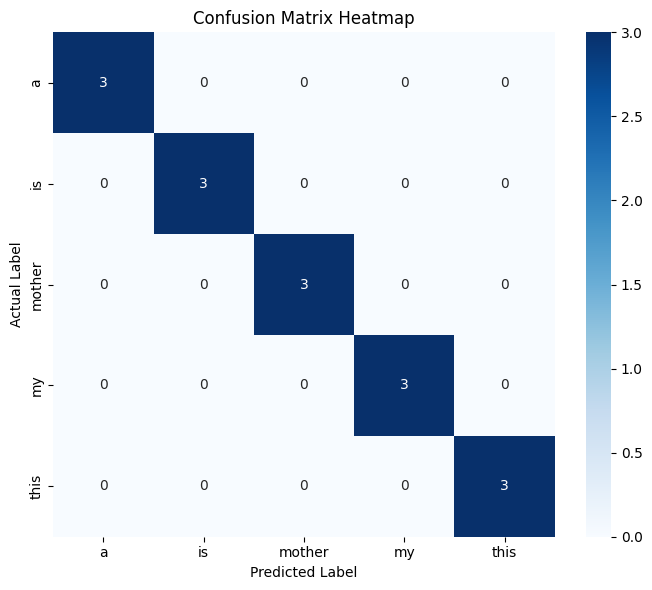

In [11]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS))

print("\nConfusion Matrix:")
cm=confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

print("\ncnfusion matrix heatmap")
# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=LABELS,   # Predicted labels
    yticklabels=LABELS    # Actual labels
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()



In [12]:
import numpy as np
from collections import defaultdict

# Convert one-hot y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Group indices by class in the test set
indices_by_class = defaultdict(list)
for idx, label in enumerate(y_test_int):
    indices_by_class[label].append(idx)

# Select up to 3 samples per class
selected_indices = []
for label in range(len(LABELS)):
    if label in indices_by_class:
        selected = indices_by_class[label][:3]  
        selected_indices.extend(selected)

# Extract those samples
X_demo = X_test[selected_indices]
y_demo_true = y_test_int[selected_indices]

# Predict
y_demo_pred = model.predict(X_demo)
y_demo_pred_labels = np.argmax(y_demo_pred, axis=1)

# Print results
print("Manual test on 3 samples per class :\n")
for i, idx in enumerate(selected_indices):
    true_label = LABELS[y_demo_true[i]]
    pred_label = LABELS[y_demo_pred_labels[i]]
    confidence = np.max(y_demo_pred[i])
    status = "CORRECT" if true_label == pred_label else "WRONG"
    print(f"{status} Sample {i+1}: True='{true_label}' | Pred='{pred_label}' | Conf={confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Manual test on 3 samples per class :

CORRECT Sample 1: True='a' | Pred='a' | Conf=1.00
CORRECT Sample 2: True='a' | Pred='a' | Conf=0.99
CORRECT Sample 3: True='a' | Pred='a' | Conf=0.99
CORRECT Sample 4: True='is' | Pred='is' | Conf=0.99
CORRECT Sample 5: True='is' | Pred='is' | Conf=0.97
CORRECT Sample 6: True='is' | Pred='is' | Conf=0.95
CORRECT Sample 7: True='mother' | Pred='mother' | Conf=0.98
CORRECT Sample 8: True='mother' | Pred='mother' | Conf=0.97
CORRECT Sample 9: True='mother' | Pred='mother' | Conf=0.77
CORRECT Sample 10: True='my' | Pred='my' | Conf=0.98
CORRECT Sample 11: True='my' | Pred='my' | Conf=0.99
CORRECT Sample 12: True='my' | Pred='my' | Conf=1.00
CORRECT Sample 13: True='this' | Pred='this' | Conf=0.96
CORRECT Sample 14: True='this' | Pred='this' | Conf=1.00
CORRECT Sample 15: True='this' | Pred='this' | Conf=1.00
